In [1]:
from astropy.io import ascii
from regions import CircleSkyRegion
from astropy.table import QTable, Table, Column
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.coordinates import Angle, Latitude, Longitude
from astropy import units as u
from astropy.table import Table, Column, join
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import regions
import re
#from regions import DS9Parser
from astropy.table import vstack
from astropy.io import fits  
import warnings
from astropy.wcs import WCS
from uncertainties import ufloat
from uncertainties.umath import *
from radio_beam import Beam
import astropy.constants as c
from astropy.visualization import quantity_support
quantity_support()
plt.rcParams.update({'font.size': 14})
import seaborn as sns
from scipy.integrate import quad
import plfit

In [2]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
base = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'
catNB3 = Table.read(base+'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB3 = Table.read(base+'catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catNB6 = Table.read(base+'catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB6 = Table.read(base+'catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')

from purify_catalog import cat_purification_cores
from purify_catalog import HII_catalogs
#cat_NB3_HII_candidates, cat_MB3_HII_candidates, cat_NB3_HII, cat_MB3_HII, cat_NB6_HII_candidates, cat_MB6_HII_candidates, cat_NB6_HII, cat_MB6_HII = HII_catalogs(catNB3, catNB6, catMB3, catMB6)
catNB3_m, catMB3_m, catNB6_m, catMB6_m = cat_purification_cores(catNB3, catMB3, catNB6, catMB6)
catNB3_HII, catNB3_HII_cand, catNB3_HII_new, catMB3_HII, catMB3_HII_cand, catMB3_HII_new, catNB6_HII, catNB6_HII_cand, catNB6_HII_new, catMB6_HII, catMB6_HII_cand, catMB6_HII_new = HII_catalogs(catNB3, catNB6, catMB3, catMB6)

Removed 198 sources for the complete catalog
Removed 9 sources for the medium catalog
Removed 81 sources for the robust catalog
Removed 186 sources for the complete catalog
Removed 7 sources for the medium catalog
Removed 47 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 6 sources for the medium catalog
Removed 58 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 8 sources for the medium catalog
Removed 32 sources for the robust catalog


/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/astropy/table/table.py:1412: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/ma/core.py:3224: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/ma/core.py:3256: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be 

In [4]:
catB3_m = vstack([catNB3_m, catMB3_m])
catB6_m = vstack([catNB6_m, catMB6_m])

In [5]:
base = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'
catNB3 = Table.read(base+'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')

In [6]:
k0 = 7.85*10**-1# * u.cm**2 / u.g
k11 = 1.37# * u.cm**2 / u.g
k13 = 1.69# * u.cm**2 / u.g
tau = 10**6 * u.yr
n_H = 10**6 * u.cm**-3

In [7]:
a = 1/2 * (log10(k0)**2 - 4*(log10(k11)**2) + 3*(log10(k13)**2))/ (log10(k0) - 4*log10(k11) + 3*log10(k13))

In [8]:
b = 1/4 * ((log10(k13) - log10(k11))*(log10(k13) - log10(k0))*(log10(k11)-log10(k0))) / (log10(k0)-4*log10(k11)+3*log10(k13))

In [9]:
X = a - np.sqrt((a - log10(k13))**2 + b*(log10(n_H*tau/(u.cm**-3*u.yr))-13)**2)

In [10]:
np.e**X#/100

1.2268768775642265

In [11]:
1.22/1.37

0.8905109489051094

In [12]:
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)

In [13]:
T = 50 * u.K
d = 8.4 * u.kpc
B3freq = 92.45* u.GHz
B6freq = 225.78 * u.GHz

kappaB3 = kappa(B3freq)
kappaB6 = kappa(B6freq)

In [14]:
def get_mass(flux, freq):
    return (flux*u.Jy * d**2 *(c.c**2)/ (2*kappa(freq)*freq**2*c.k_B*T)).to(u.Msun)

In [15]:
mask = catB3_m['radial_d_px'] < 1239

In [16]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

def apperture_corr(cat):
    true = quad(gaussian, -np.inf, np.inf)[0]
    adjusted_flux_array = []
    for core in cat:
        min_value = core['ring_std'] * 4 # multiplying by 4 beacause the min_value was set to 4 sigma
        peak_flux = core['peak']
        a = min_value / peak_flux
        crop = np.sqrt(-2*np.log(a))
        ratio_true_obs = true / (quad(gaussian, -crop, crop)[0])
        
        adjusted_flux = core['flux'] * ratio_true_obs
        
        adjusted_flux_array += [adjusted_flux]
        
    return adjusted_flux_array

In [17]:
mass_B3_total_corr = get_mass(apperture_corr(catB3_m), B3freq)
mass_B6_total_corr = get_mass(apperture_corr(catB6_m), B6freq)
mass_B3_errors_corr = get_mass(catB3_m['ring_std'].value, B3freq)

In [18]:
# Masses based on the brightest pixel
mass_B3_pix = get_mass(catB3_m['peak'].value, B3freq)
mass_B6_pix = get_mass(catB6_m['peak'].value, B6freq)

In [19]:
x = np.logspace(1,2.2,100)
y = ((x/8.5)**(-1.35))
a = np.logspace(1,2.2,100)
b = ((x/8.5)**(-1.38193))

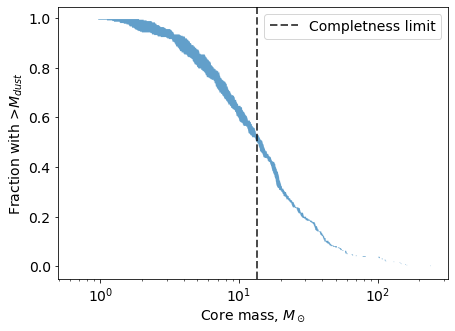

In [20]:
plt.figure(figsize=(7, 5))
sorted_core_masses_low = np.sort(mass_B3_total_corr.value-mass_B3_errors_corr.value)
sorted_core_masses_high = np.sort(mass_B3_total_corr.value+mass_B3_errors_corr.value)

cdf = 1 - np.arange(1, len(mass_B3_total_corr) + 1) / len(mass_B3_total_corr)

plt.fill_betweenx(cdf, sorted_core_masses_low, sorted_core_masses_high, step = 'pre', alpha = 0.7)
plt.xscale('log')
plt.ylabel(r'Fraction with >$M_{dust}$')
plt.xlabel(r'Core mass, $M_\odot$')
#plt.plot(x,y, label = r'Salpeter $\Gamma = 1.35$', color = 'r', linestyle = ':')
plt.axvline(13.5, linestyle = '--', color = 'k', label='Completness limit', alpha = 0.7)

plt.legend()

In [21]:
p = plfit.plfit(mass_B3_total_corr.value[mass_B3_total_corr.value > 15.5])

PYTHON plfit executed in 0.006290 seconds
Not enough data left after flagging low S/N points.  Using all data.
xmin: 16.0534 n(>xmin): 163 alpha: 2.46859 +/- 0.115029   Log-Likelihood: -663.824   ks: 0.0748105 p(ks): 0.153478


/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/plfit/plfit.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  a = 1+float(n) / sum(log(x/xmin))


In [22]:
p = plfit.plfit(mass_B3_total_corr.value[mass_B3_total_corr.value > 11])

PYTHON plfit executed in 0.006488 seconds
xmin: 13.7438 n(>xmin): 191 alpha: 2.38193 +/- 0.0999931   Log-Likelihood: -767.959   ks: 0.0976695 p(ks): 0.0244091


(1, 100)

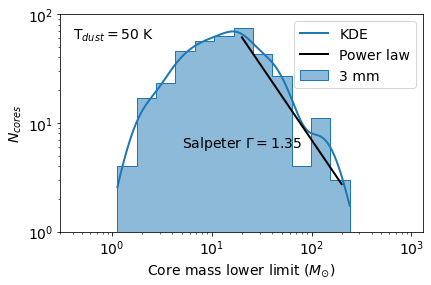

In [23]:
fig = plt.figure(figsize=(6.5,4))
bins=np.logspace(-1,3,23)

x1 = 200 # ending point for slope 1
y1 = 20 # starting point, x
y2 = 61 #starting point, y

l = np.log10(x1)-np.log10(y1)

s1 = 1.35
s2 = 1.35
s3 = 3
x2 = 10**(np.log10(y2) - l*s1)





#plt.hist(mass_B3_total, bins=bins, label = '3 mm', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2)
#plt.hist(mass_B6_total, bins=bins, label = '1 mm', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2)
sns.histplot(mass_B3_total_corr,log_scale = (True, True), kde = True, fill = True, bins=12, element="step", label = '3 mm', 
             color='tab:blue', alpha = 0.5, ec='tab:blue', linewidth=1)
#sns.kdeplot(mass_B3_total,log_scale = (True, True),common_norm=False)

#plt.plot([x1, y1],[10**(np.log10(y2) - l*s1),y2], color='k', label = 'Power law')
plt.plot([x1, y1],[10**(np.log10(y2) - l*s2),y2], color='k',)
#plt.plot([x1, y1],[10**(np.log10(y2) - l*s3),y2], color='k',)
#plt.text(x1*1.05,10**(np.log10(y2) - l*s2), ' 2aaaaa', fontsize=14)
plt.text(5, 6, r'Salpeter $\Gamma = 1.35$')
#plt.text(80, 13, r'$\alpha \approx 1$')
plt.text(0.4, 60, r'T$_{dust} = 50$ K') 


plt.xlabel(r'Core mass lower limit ($M_{\odot}$)')
plt.ylabel(r'$N_{cores}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(['KDE', 'Power law', '3 mm'], loc='upper right')
plt.xlim(3*10**-1, 1.3*10**3)
plt.ylim(1, 100)

#plt.savefig('masses_poster.png', dpi=300,bbox_inches='tight')

In [24]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

def apperture_corr(cat):
    true = quad(gaussian, -np.inf, np.inf)[0]
    adjusted_flux_array = []
    for core in cat:
        min_value = core['ring_std'] * 4 # multiplying by 4 beacause the min_value was set to 4 sigma
        peak_flux = core['peak']
        a = min_value / peak_flux
        crop = np.sqrt(-2*np.log(a))
        ratio_true_obs = true / (quad(gaussian, -crop, crop)[0])
        
        adjusted_flux = core['flux'] * ratio_true_obs
        
        adjusted_flux_array += [adjusted_flux]
        
    return adjusted_flux_array

In [25]:
mass_B3_total_corr = get_mass(apperture_corr(catB3_m), B3freq)
mass_B6_total_corr = get_mass(apperture_corr(catB6_m), B6freq)

(1, 100)

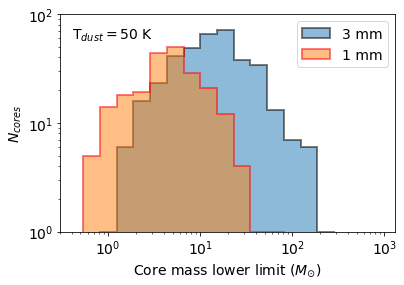

In [26]:
#fig = plt.figure(figsize=(6.5,4))
bins=np.logspace(-1,3,23)

x1 = 200 # ending point for slope 1
y1 = 20 # starting point, x
y2 = 61 #starting point, y

l = np.log10(x1)-np.log10(y1)

s1 = 1.35
s2 = 1.35
s3 = 3
x2 = 10**(np.log10(y2) - l*s1)





plt.hist(mass_B3_total_corr, bins=bins, label = '3 mm', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2)
plt.hist(mass_B6_total_corr, bins=bins, label = '1 mm', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2)
#plt.hist(mass_B3_total, bins=bins, label = '3 mm', alpha = 1, ec='k',histtype='step',linewidth=2)
#plt.hist(mass_B6_total, bins=bins, label = '1 mm', alpha = 1, ec='r',histtype='step',linewidth=2)
#sns.histplot(mass_B3_total,log_scale = (True, True), kde = True, fill = True, bins=12, element="step", label = '3 mm', 
#             color='tab:blue', alpha = 0.5, ec='tab:blue', linewidth=1)
#sns.kdeplot(mass_B3_total,log_scale = (True, True),common_norm=False)

#plt.plot([x1, y1],[10**(np.log10(y2) - l*s1),y2], color='k', label = 'Power law')
#plt.plot([x1, y1],[10**(np.log10(y2) - l*s2),y2], color='k',)
#plt.plot([x1, y1],[10**(np.log10(y2) - l*s3),y2], color='k',)
#plt.text(5, 6, r'Salpeter $\Gamma = 1.35$')
#plt.text(80, 13, r'$\alpha \approx 1$')
plt.text(0.4, 60,r'T$_{dust} = 50$ K', fontsize=14) 


plt.xlabel(r'Core mass lower limit ($M_{\odot}$)')
plt.ylabel(r'$N_{cores}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.legend(['KDE', 'Power law', '3 mm'], loc='upper right')
plt.xlim(3*10**-1, 1.3*10**3)
plt.ylim(1, 100)

#plt.savefig('masses.png', dpi=300,bbox_inches='tight')

Text(0, 0.5, 'adjusted / cataloged flux')

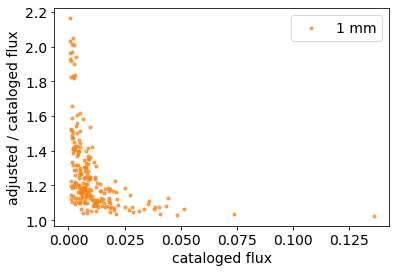

In [27]:
plt.scatter(catB6_m['flux'], apperture_corr(catB6_m)/catB6_m['flux'], color='tab:orange', alpha = 0.7, marker = '.', label = '1 mm')
plt.legend()
plt.xlabel('cataloged flux')
plt.ylabel('adjusted / cataloged flux')

Text(0, 0.5, 'adjusted / cataloged flux')

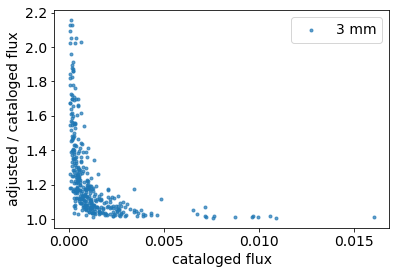

In [28]:
plt.scatter(catB3_m['flux'], apperture_corr(catB3_m)/catB3_m['flux'], color='tab:blue', alpha = 0.7, marker = '.', label = '3 mm')
plt.legend()
plt.xlabel('cataloged flux')
plt.ylabel('adjusted / cataloged flux')

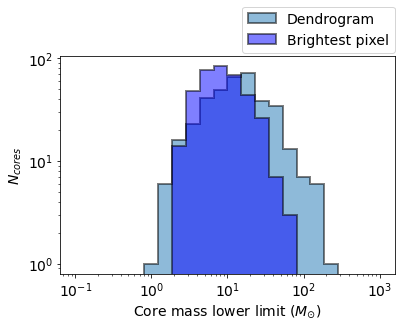

In [29]:
#plt.text(x1*1.05,10**(np.log10(y2) - l*s2), '2', fontsize=14)bins=np.logspace(-1,3,23)
#bins=np.logspace(-1,2.5,30)
#plt.hist(mass_B3, bins=bins, label = '3 mm', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2)
#plt.hist(mass_B6, bins=bins, label = '1 mm', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2)

plt.hist(mass_B3_total_corr, bins=bins, label = 'Dendrogram', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2)
#plt.hist(mass_B6_total, bins=bins, label = '1 mm', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2)

plt.hist(mass_B3_pix, bins = bins, label = 'Brightest pixel', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2, color = 'blue')
#plt.hist(mass_B3_pix_r, bins = bins, label = '3 mm, px r', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2, color = 'red')
#plt.hist(mass_B6_pix, bins = bins, label = '1 mm, px', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2)

#plt.hist(mass_B3_total_r, bins=bins, label = '3 mm', ec='k',histtype='step',linewidth=2,linestyle='--')
#plt.hist(mass_B6_total_r, bins=bins, label = '1 mm', ec='r',histtype='step',linewidth=2,linestyle='--')
plt.xlabel(r'Core mass lower limit ($M_{\odot}$)')
plt.ylabel(r'$N_{cores}$')

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.02, 1.26))

#plt.title('Mass lower limit, total flux')
#plt.savefig('masses_dendro_vs_pix_3mm.png', dpi=300,bbox_inches='tight')

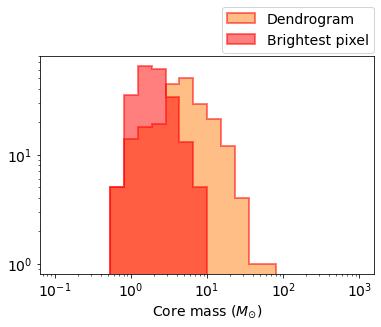

In [30]:
bins=np.logspace(-1,3,23)
#bins=np.logspace(-1,2.5,30)
#plt.hist(mass_B3, bins=bins, label = '3 mm', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2)
#plt.hist(mass_B6, bins=bins, label = '1 mm', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2)

#plt.hist(mass_B3_total, bins=bins, label = '3 mm', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2)
plt.hist(mass_B6_total_corr, bins=bins, label = 'Dendrogram', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2, color = 'tab:orange')

#plt.hist(mass_B3_pix, bins = bins, label = '3 mm, px', alpha = 0.5, ec='k',histtype='stepfilled',linewidth=2, color = 'blue')
plt.hist(mass_B6_pix, bins = bins, label = 'Brightest pixel', alpha = 0.5, ec='r',histtype='stepfilled',linewidth=2, color = 'red')

#plt.hist(mass_B3_total_r, bins=bins, label = '3 mm', ec='k',histtype='step',linewidth=2,linestyle='--')
#plt.hist(mass_B6_total_r, bins=bins, label = '1 mm', ec='r',histtype='step',linewidth=2,linestyle='--')
plt.xlabel(r'Core mass ($M_{\odot}$)')

plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.title('Mass lower limit, total flux')
plt.legend(bbox_to_anchor=(1.02, 1.26))
#plt.savefig('masses_dendro_vs_pix_1mm.png', dpi=300,bbox_inches='tight')

In [31]:
def running_histogram(X, nBins=100, binSize=None, normFac=None):
    """ Create a adaptive histogram of a (x) point set using some number of bins. """
    if binSize is not None:
        nBins = round( (X.max()-X.min()) / binSize )

    bins = np.linspace(X.min(),X.max(), nBins)
    delta = bins[1]-bins[0]

    running_h   = []
    bin_centers = []

    for i, bin in enumerate(bins):
        binMax = bin + delta
        w = np.where((X >= bin) & (X < binMax))

        if len(w[0]):
            running_h.append( len(w[0]) )
            bin_centers.append( np.nanmedian(X[w]) )

    if normFac is not None:
        running_h /= normFac

    return bin_centers, running_h

In [32]:
x = np.logspace(1,2.2,100)
y = ((x/100)**(-2.35))

In [33]:
a = np.logspace(1,2.2,100)
b = ((a/100)**(-2.38193))

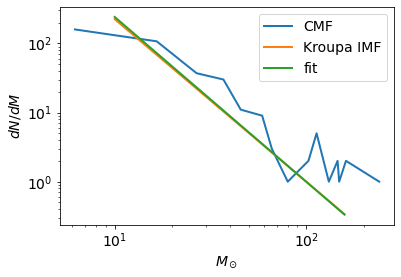

In [34]:
binSize = 10
#normFac=boxSizeCubicMpc*binSize
normFac = None
xm, ym = running_histogram(mass_B3_total_corr.value, binSize=binSize, normFac=normFac)
plt.plot(xm, ym, label = 'CMF')
plt.loglog()
plt.xlabel(r'$M_\odot$')
plt.ylabel(r'$dN/dM$')
plt.plot(x,y, label = 'Kroupa IMF')
plt.plot(a,b, label = 'fit')
plt.legend()
